# Step 3: spectrum and light curve from DL3 data

In this notebook DL3 data are provided to Gammapy to

define the target (Crab) position, evaluate number of excess and backgroun events, plot the on and off regions, plot the significance along llivetime, fit our data with a LogParabola (to match with 

>pyirf.spectral.CRAB_MAGIC_JHEAP2015 = LogParabola(3.23e-11 1 / (cm2 s TeV) \* (E / 1.0 TeV)\*\*(-2.47 + -0.24 * log10(E / 1.0 TeV)))

reference), plot the number of events vs. energy, evaluate the SED ($E^2*dn/dE/(A*T)$), evaluate the light curve (flux in time bins) and compare our results to the MAGIC reference.

You can provide one or two sets of DL3 files (e.g. to compare SEDs with different interpolations or weights).


### As usual, let's start by loading some modules (and checking Gammapy version)

In [37]:
import itertools
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib import pyplot as plt

In [38]:
# Due to the dependencies on other packages, gammapy v0.19 is installed
# in the current magic-cta-pipe environment, but it is already outdated.
# In order to use the latest features, such as dynamic theta cuts and
# the wobble region finder, please run this notebook with a different
# environment where newer versions of gammapy are installed.

import gammapy

print(f"gammapy: v{gammapy.__version__}")

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from regions import CircleSkyRegion, PointSkyRegion

gammapy: v0.20.1


In [39]:
# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Get the default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load DL3 data files

Here you can provide DL3 data files. You will have to provide directories where you stored DL3 runs and index files.

In this example we use the data downloaded in the directories ./data/DL3_dyn_int and ./data/DL3_int

If you want to process only one set of DL3 files, please set `input_dir_1 = ""`.

Let's start by creating DataStore objects from input directories and take a look at one of them.

In [40]:
# ================
# === Settings ===
# ================

input_dir = '/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_dyn_int/'
    
input_dir_1 = '/fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_int/'

# === Main ===
# ============

print(f"Input directory: {input_dir}")
print(f"Input directory: {input_dir_1}")

double = True
if input_dir_1=='':
    double = False

data_store = DataStore.from_dir(input_dir)
if double:
    data_store_1 = DataStore.from_dir(input_dir_1)
# Show the observation table
data_store.obs_table


Input directory: /fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_dyn_int/
Input directory: /fefs/aswg/workspace/elisa.visentin/MAGIC_LST_analysis/Crab_2/DL3_int/


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes10,bytes10
2923,2020-11-18,23:35:47.415,2020-11-18,23:52:39.650,83.96696805679441,22.24638287152439,45.06171120796383,44.93828879203617,86.40431692412777,83.63333333,22.01333333,1605742547.414514,1605743559.649549,451.3736107349396,1012.235034465789,409.0913326624333,0.906325321049095,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
2924,2020-11-18,23:56:14.698,2020-11-19,00:15:55.933,83.26503262048294,21.7876915585711,40.10371827458638,49.89628172541362,89.6596903830588,83.63333333,22.01333333,1605743774.698224,1605744955.932863,536.2971684932709,1181.234639644619,487.0149766340357,0.9081065596566663,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3093,2020-12-07,23:34:47.190,2020-12-07,23:36:13.672,83.97885081403817,22.24526920857109,28.896547521311618,61.10345247868838,95.75666061818394,83.63333333,22.01333333,1607384087.190233,1607384173.672199,39.02381253242493,86.48196649551103,36.69248074225411,0.9402587384758034,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3265,2020-12-15,21:27:18.415,2020-12-15,21:41:43.146,83.96475780330954,22.247863563275,49.9494782005039,40.0505217994961,84.08107653962642,83.63333333,22.01333333,1608067638.414856,1608068503.145767,472.7662608623505,864.7309117317188,449.7320408635144,0.9512777837470456,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3266,2020-12-15,21:43:24.497,2020-12-15,21:57:30.340,83.26300698928598,21.7877022954978,45.96227389775927,44.03772610224073,86.64186055227022,83.63333333,22.01333333,1608068604.496795,1608069450.340243,462.2223224639893,845.8434472083973,440.4028394825901,0.9527943980180684,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
3267,2020-12-15,21:59:19.731,2020-12-15,22:12:55.664,83.96675054673734,22.24606302455202,42.93517607753816,47.06482392246184,87.45572611833191,83.63333333,22.01333333,1608069559.731362,1608070375.663918,439.3872592449188,815.932556152341,418.9587482320345,0.9535068198199681,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2021-02-13,23:09:15.761,2021-02-13,23:26:01.783,83.28785259632826,21.78673659083378,27.93920269216776,62.06079730783224,262.4862245311674,83.63333333,22.01333333,1613257755.761256,1613258761.783382,407.7805027961731,1006.022126674656,392.9189927423401,0.9635551235237417,Crab,WOBBLE,3,LST1_M1_M2,LST1_M1_M2


Let's take a look at the observations (runs) features.

If `obs_ids = None` you will process all the runs. If you want to use only some of the runs, please put the runs list (comma separated numbers) after `obs_ids =`

In [41]:
# ================
# === Settings ===
# ================



obs_ids = None   # `None` means "all" observations
obs_ids_1 = None

# ============
# === Main ===
# ============

observations = data_store.get_observations(obs_ids, required_irf="point-like")
if double:
    observations_1 = data_store_1.get_observations(obs_ids_1, required_irf="point-like")
print(observations)




Observations
Number of observations: 16
Observation

	obs id            : 2923 
 	tstart            : 59171.98
	tstop             : 59171.99
	duration          : 1012.24 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 9.4%
Observation

	obs id            : 2924 
 	tstart            : 59172.00
	tstop             : 59172.01
	duration          : 1181.23 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 3093 
 	tstart            : 59190.98
	tstop             : 59190.98
	duration          : 86.48 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 6.0%
Observation

	obs id            : 3265 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.73 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.9%
Observation

	obs id            : 3266 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 845.84 s
	pointing (icrs)   : 83.3 deg, 21.8 

### Define a target region

Here we will define the target position from observations metadata. To define the `on_region` we use `CircleSkyRegion` in case of global theta cuts, `PointSkyRegion` in case of dynamic theta cuts.

In [42]:
# Get metadata from the first observation
observation = observations[0]

event_meta = observation.events.table.meta
aeff_meta = observation.aeff.meta

# Define a target position
target_position = SkyCoord(
    u.Quantity(event_meta["RA_OBJ"], u.deg),
    u.Quantity(event_meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in aeff_meta:
    # Get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta["RAD_MAX"] * u.deg
    
    # Use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
    
else:
    # Use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)
    
print(on_region)

Region: PointSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>


We define an `on_region_1` in case we provided a second input sample (because the two datasets can have different types of theta cuts)

In [43]:
if double:
    # Get metadata from the first observation
    observation_1 = observations_1[0]

    event_meta_1 = observation_1.events.table.meta
    aeff_meta_1 = observation_1.aeff.meta

    # Define a target position
    target_position_1 = SkyCoord(
        u.Quantity(event_meta["RA_OBJ"], u.deg),
        u.Quantity(event_meta["DEC_OBJ"], u.deg),
        frame="icrs",
    )

    if "RAD_MAX" in aeff_meta:
        # Get the global theta cut used for creating the IRFs
        on_region_radius = aeff_meta["RAD_MAX"] * u.deg

        # Use the circle sky region to apply the global theta cut
        on_region_1 = CircleSkyRegion(center=target_position, radius=on_region_radius)

    else:
        # Use the point sky region to apply dynamic theta cuts
        on_region_1 = PointSkyRegion(target_position_1)

    print(on_region_1)

Region: PointSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63333333, 22.01333333)>


### Run the data reduction chain

Here we create the energy axes 9reconstructed and true energy) and we set the number of off regions.

We also create the Gammapy Makers needed to process data

In [44]:
# ================
# === Settings ===
# ================

energy_min = "0.030 TeV"
energy_max = "30. TeV"
n_bins_pdec = 5

true_energy_min = "0.01 TeV"
true_energy_max = "100 TeV"
n_bins_pdec_true = 10

n_off_regions = 3

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    nbin=n_bins_pdec,
    per_decade=True,
    name="energy",
)

energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name="energy_true",
)

print("Energy axis:")
print(energy_axis.edges)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# Create a spectrum dataset maker
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

# Create a background maker
print(f"\nNumber of OFF regions: {n_off_regions}")

region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# Create a safe mask maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

Energy axis:
[3.00000000e-02 4.75467958e-02 7.53565929e-02 1.19432151e-01
 1.89287203e-01 3.00000000e-01 4.75467958e-01 7.53565929e-01
 1.19432151e+00 1.89287203e+00 3.00000000e+00 4.75467958e+00
 7.53565929e+00 1.19432151e+01 1.89287203e+01 3.00000000e+01] TeV

Number of OFF regions: 3


here we create again the makers for the second sample provided

In [45]:
if double:
    on_geom_1 = RegionGeom.create(region=on_region_1, axes=[energy_axis])
    dataset_empty_1 = SpectrumDataset.create(geom=on_geom_1, energy_axis_true=energy_axis_true)
    # Create a spectrum dataset maker
    dataset_maker_1 = SpectrumDatasetMaker(
        containment_correction=False,
        selection=["counts", "exposure", "edisp"],
        use_region_center=True,
    )

    # Create a background maker
    print(f"\nNumber of OFF regions: {n_off_regions}")

    region_finder_1 = WobbleRegionsFinder(n_off_regions=n_off_regions)
    bkg_maker_1 = ReflectedRegionsBackgroundMaker(region_finder=region_finder_1)

    # Create a safe mask maker
    safe_mask_maker_1 = SafeMaskMaker(methods=["aeff-max"], aeff_percent=3)


Number of OFF regions: 3


We loop over observations to run the makers over them and create datasets that collect e.g. number of events, number of excess and background events, exposure and $\alpha = 1/Numberoffregions$ 

In [46]:
datasets = Datasets()

counts = Map.create(skydir=target_position, width=3)

# Loop over every observation
print("Running the makers...")

n_observations = len(observations)

for i_obs, observation in enumerate(observations):
    
    if (i_obs % 10) == 0:
        print(f"{i_obs}/{n_observations}")
    
    obs_id = observation.obs_id
    
    # Fill the number of events in the map
    counts.fill_events(observation.events)

    # Run the makers to the observation data
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(f"{n_observations}/{n_observations}")

# Get the information table
info_table = datasets.info_table(cumulative=True)
print(datasets.energy_ranges)
# Show the table
info_table

Running the makers...
0/16
10/16
16/16
(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,233,214.6666717529297,19.919425790772696,18.33333396911621,72.00000088848171,72.00000088848171,nan,1039.865966796875,251247584.0,917.4142425893486,1012.2350344657898,0.2539746923291391,0.019983703236796758,0.2339909953294876,15,11,wstat,435.1844975450938,55,11.0,33.0,0.3333333432674408
stacked,590,527.0,29.68694833958435,63.0,194.75000435300166,194.75000435300166,nan,296.190673828125,483604192.0,1990.101167344309,2193.4696741104126,0.29646734029472765,0.03165668209926753,0.2648106581954601,15,12,wstat,988.166359320556,189,12.0,36.0,0.3333333432674408
stacked,619,554.0,30.530330527659626,65.0,203.5000045485794,203.5000045485794,nan,407.8461608886719,496157952.0,2071.4165920622877,2279.9516406059265,0.2988293143793581,0.03137949181689544,0.2674498225624627,15,12,wstat,1039.3626153608902,195,12.0,36.0,0.3333333432674408
stacked,732,661.3333129882812,33.85098469842138,70.66667175292969,236.000005275011,236.000005275011,nan,407.8461608886719,783803072.0,2894.0158973120006,3144.6825523376465,0.2529357218389474,0.024418204412272167,0.22851751215414406,15,12,wstat,1259.3870577848024,212,12.0,36.0,0.3333333432674408
stacked,960,871.0,39.11212580165499,89.00000762939453,306.750013561919,306.750013561919,nan,407.8461608886719,1015431040.0,3699.93079541246,3990.525999546051,0.2594643124650609,0.024054506030152113,0.2354098084969459,15,12,wstat,1677.5282853339297,267,12.0,35.999996185302734,0.3333333730697632
stacked,1133,1027.0,42.4065570346647,106.0,362.7500112764535,362.7500112764535,nan,407.8461608886719,1211248384.0,4477.928052216859,4806.458555698395,0.2530188039620451,0.02367166215355409,0.22934714180849103,15,12,wstat,1946.527212501898,318,12.0,36.0,0.3333333432674408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,2144,1919.333251953125,56.84802326299689,224.66668701171875,704.5000494755791,704.5000494755791,nan,12839.0185546875,1816723456.0,8471.016919146381,8971.379978656769,0.2530983021830689,0.026521808320784025,0.22657648665711022,15,13,wstat,3581.3026303092993,674,13.0,38.999996185302734,0.3333333730697632


Again for the second sample

In [47]:
if double :
    datasets_1 = Datasets()

    counts_1 = Map.create(skydir=target_position_1, width=3)

    # Loop over every observation
    print("Running the makers...")

    n_observations_1 = len(observations_1)

    for i_obs, observation in enumerate(observations_1):

        if (i_obs % 10) == 0:
            print(f"{i_obs}/{n_observations_1}")

        obs_id = observation.obs_id

        # Fill the number of events in the map
        counts_1.fill_events(observation.events)

        # Run the makers to the observation data
        dataset = dataset_maker_1.run(dataset_empty_1.copy(name=str(obs_id)), observation)
        dataset_on_off = bkg_maker_1.run(dataset, observation)
        dataset_on_off = safe_mask_maker_1.run(dataset_on_off, observation)

        datasets_1.append(dataset_on_off)

    print(f"{n_observations_1}/{n_observations_1}")

    # Get the information table
    info_table_1 = datasets_1.info_table(cumulative=True)
    print(datasets_1.energy_ranges)
        

Running the makers...
0/16
10/16
16/16
(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


In [48]:
if double:
    # Show the table
    print(info_table_1)

  name  counts       excess      ...   acceptance_off          alpha       
                                 ...                                       
------- ------ ----------------- ... ------------------ -------------------
stacked    375 300.6666564941406 ...               36.0  0.3333333432674408
stacked    842 684.6666870117188 ... 36.000003814697266  0.3333333134651184
stacked    888             724.0 ...               39.0  0.3333333432674408
stacked   1202 984.6666259765625 ...               39.0  0.3333333432674408
stacked   1559            1263.0 ... 38.999996185302734  0.3333333730697632
stacked   1904 1536.333251953125 ... 38.999996185302734  0.3333333730697632
    ...    ...               ... ...                ...                 ...
stacked   3189  2549.66650390625 ...               42.0  0.3333333432674408
stacked   3580 2850.333251953125 ... 41.999996185302734  0.3333333730697632
stacked   4136 3297.333251953125 ... 41.999996185302734  0.3333333730697632
stacked   44

### Some plots (first sample)

Fisrt a map of on-off regions and number of events in RA-DEC coordinates. Almost all of the events come from the Crab position (as expected)

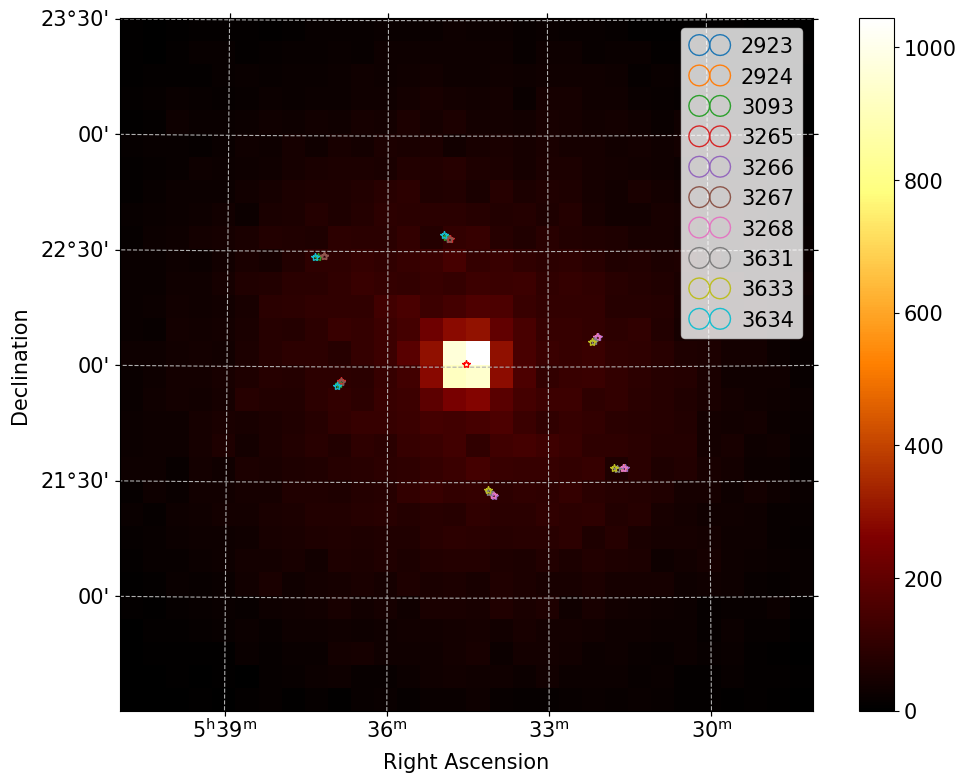

In [49]:
plt.figure()

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor="red")

# Plot the OFF positions (only the first part of observations)
if n_observations < 10:
    plot_spectrum_datasets_off_regions(datasets, ax)
else:
    plot_spectrum_datasets_off_regions(datasets[0:10], ax)

ax.grid()

Plot of number of events and significance (sqrt(TS), in $\sigma$ units) along livetime (= measurements time). Number of excess events and significance increase with livetime, and we get a 50 $\sigma$ signaficance in less than 2 hours (high intensity source)

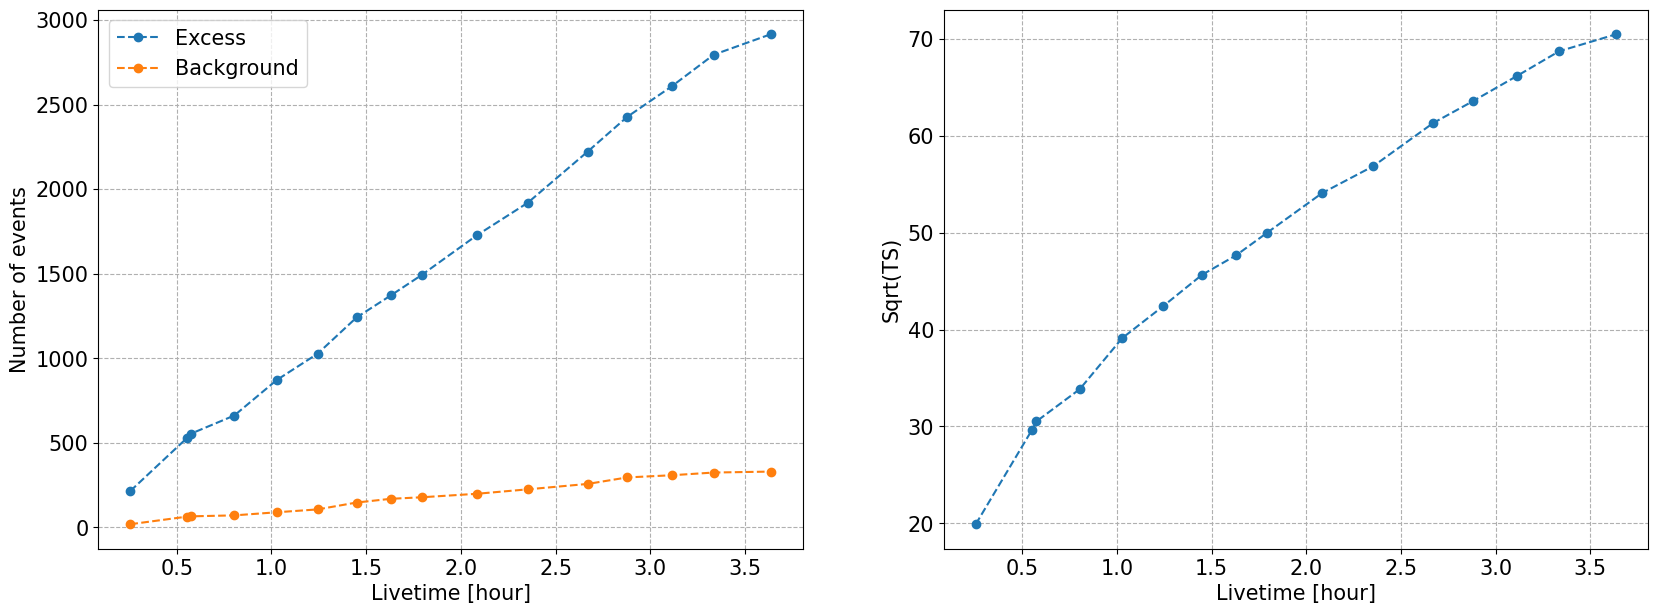

In [50]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

### Fit the spectrum

We use a LogParabola to fit our datasets: after creating a `SkyModel` and adding it to our satasets, we create a `Fit` that we will run on our data 

In [51]:
source_name="Crab Nebula"

spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit="cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit="TeV"),
)

# ============
# === Main ===
# ============

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# Add the model to the stacked dataset
stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

if double:    
    stacked_dataset_1 = datasets_1.stack_reduce()
    stacked_dataset_1.models = [sky_model]

# Create a fit to be runned on datasets
fit = Fit()

Here we run the fit on the first sample to get the LogParabola parameters ($\Phi = amplitude*(E/reference)^{(-\alpha -\beta*log10(E/reference)} $

In [52]:
results = fit.run(datasets=stacked_dataset)
print(results)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the fitted parameters
stacked_dataset.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 164
	total stat : 4.49

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,3.3938e-11,cm-2 s-1 TeV-1,1.025e-12,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.5189e+00,,2.993e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,1.3358e-01,,1.873e-02,nan,nan,False,False,


Same on the second sample

In [53]:
if double:    
    results_1 = fit.run(datasets=stacked_dataset_1)
    print(results_1)

    # Keep the best fit model
    best_fit_model_1 = stacked_dataset_1.models[0].spectral_model.copy()

    

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 68
	total stat : 5.37

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [54]:
if double:
    # Show the fitted parameters
    print(stacked_dataset_1.models.to_parameters_table())


   model      type      name     value    ... max frozen is_norm link
----------- -------- --------- ---------- ... --- ------ ------- ----
Crab Nebula spectral amplitude 3.2181e-11 ... nan  False    True     
Crab Nebula spectral reference 1.0000e+00 ... nan   True   False     
Crab Nebula spectral     alpha 2.4966e+00 ... nan  False   False     
Crab Nebula spectral      beta 9.5930e-02 ... nan  False   False     


### Plots

Here we plto the number of excess events and compare it to the number of predicted events to plot the residuals

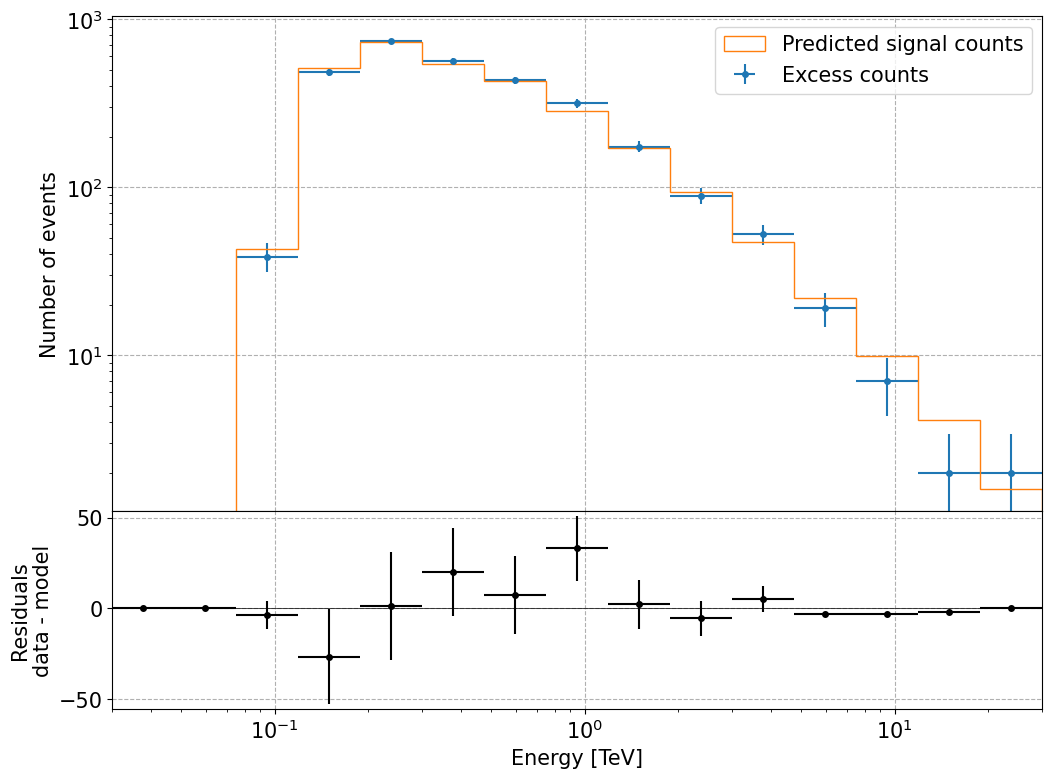

In [55]:
plt.figure()

# Plot the number of excess and predicted events
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

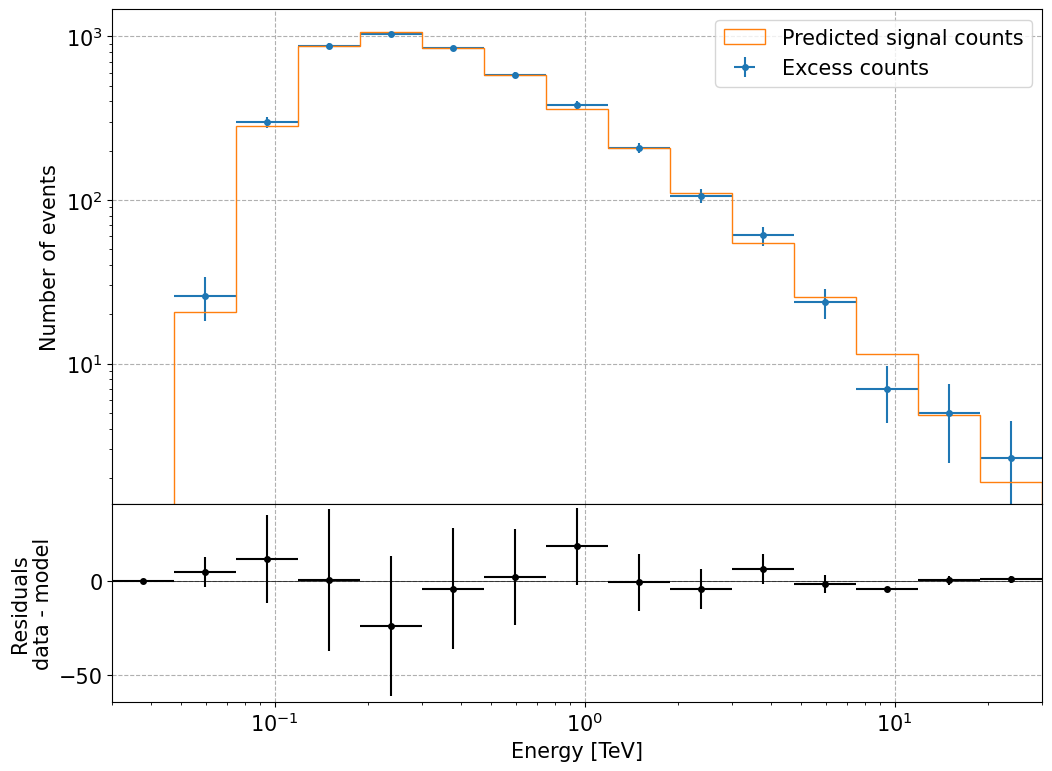

In [56]:
if double:
    plt.figure()

    # Plot the number of excess and predicted events
    ax_spectrum, ax_residuals = stacked_dataset_1.plot_fit()

    ax_spectrum.set_ylabel("Number of events")
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    ax_residuals.grid()

### Estimate the flux points

We create a `FluxPointsEstimator` object to be runned on our datasets to evaluate the SED (`sed_type="e2dnde"`)

In [57]:
# Create a flux point estimator
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source=source_name, selection_optional="all"
)

First on the first sample

In [58]:
# Run the flux point estimator to the datasets
print("Running the flux points estimator...")
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# Show the flux points table
flux_points.to_table(sed_type="e2dnde", formatted=True)

Running the flux points estimator...


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.038,0.030,0.048,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.060,0.048,0.075,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.095,0.075,0.119,5.527e-11,1.086e-11,1.130e-11,1.045e-11,7.877e-11,39.647,6.297,52.999759376598355,38.6664,0.000,False,53.0,True,0.200 .. 5.000,22.080 .. 191.823
0.150,0.119,0.189,5.519e-11,2.991e-12,3.025e-12,2.956e-12,6.131e-11,539.135,23.219,640.0369293602851,485.37323,0.000,False,640.0,True,0.200 .. 5.000,306.209 .. 2288.071
0.238,0.189,0.300,5.397e-11,2.170e-12,2.193e-12,2.147e-12,5.840e-11,1158.912,34.043,841.997651279885,736.66425,0.000,False,842.0,True,0.200 .. 5.000,665.499 .. 3330.339
0.378,0.300,0.475,4.945e-11,2.159e-12,2.188e-12,2.131e-12,5.389e-11,1167.608,34.170,588.9777339370826,560.3107,0.000,False,589.0,True,0.200 .. 5.000,673.293 .. 2467.757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.383,1.893,3.000,1.832e-11,1.994e-12,2.063e-12,1.927e-12,2.259e-11,195.398,13.978,91.99969511275678,88.66636,0.000,False,92.0,True,0.200 .. 5.000,105.044 .. 461.593


Now on the second sample

In [59]:
if double:
    # Run the flux point estimator to the datasets
    print("Running the flux points estimator...")
    flux_points_1 = flux_points_estimator.run(datasets=stacked_dataset_1)

    

Running the flux points estimator...


In [60]:
if double:
    # Show the flux points table
    print(flux_points_1.to_table(sed_type="e2dnde", formatted=True))

e_ref  e_min  e_max  ... success   norm_scan         stat_scan     
 TeV    TeV    TeV   ...                                           
------ ------ ------ ... ------- -------------- -------------------
 0.038  0.030  0.048 ...   False 0.200 .. 5.000          nan .. nan
 0.060  0.048  0.075 ...    True 0.200 .. 5.000     9.619 .. 56.817
 0.095  0.075  0.119 ...    True 0.200 .. 5.000 137.399 .. 1058.368
 0.150  0.119  0.189 ...    True 0.200 .. 5.000 466.284 .. 3535.016
 0.238  0.189  0.300 ...    True 0.200 .. 5.000 725.449 .. 4682.857
 0.378  0.300  0.475 ...    True 0.200 .. 5.000 713.114 .. 3828.206
 0.599  0.475  0.754 ...    True 0.200 .. 5.000 588.246 .. 2667.704
 0.949  0.754  1.194 ...    True 0.200 .. 5.000 410.848 .. 1615.607
 1.504  1.194  1.893 ...    True 0.200 .. 5.000  237.455 .. 980.965
 2.383  1.893  3.000 ...    True 0.200 .. 5.000  111.276 .. 528.407
 3.777  3.000  4.755 ...    True 0.200 .. 5.000   75.070 .. 236.021
 5.986  4.755  7.536 ...    True 0.200 .. 5.000 

### SED plot

We plot our SEDs (flux points and best fit) on the same plot. We also plot the Crab reference SED (MAGIC, JHEAp 2015)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 3.2300e-11 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.4700e+00                ... nan  False   False     
spectral      beta 1.0423e-01                ... nan  False   False     


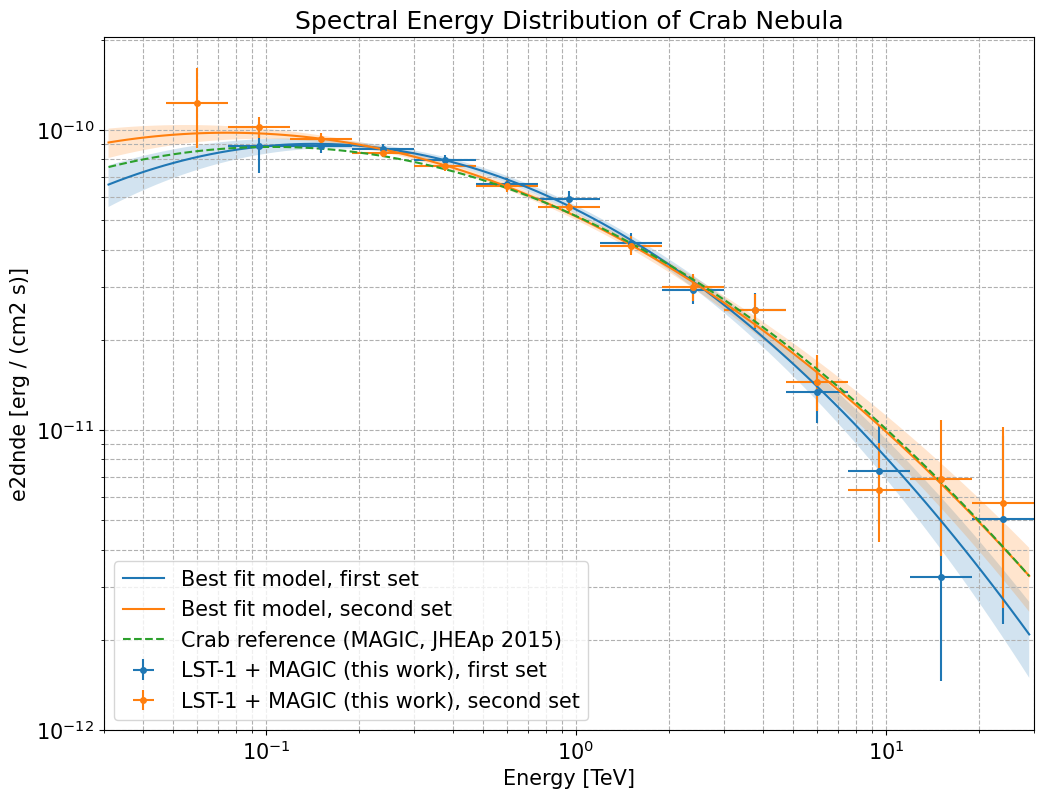

In [61]:
# ================
# === Settings ===
# ================

sed_type = "e2dnde"
yunits = u.Unit("erg cm-2 s-1")

crab_model = create_crab_spectral_model("magic_lp")
print(crab_model)
reference_models = {
    "Crab reference (MAGIC, JHEAp 2015)": crab_model,
    
}

# ============
# === Main ===
# ============

plt.figure()

energy_bounds = energy_axis.edges[[0, -1]]

lines = itertools.cycle(["--", "-.", ":"])

# Plot the flux points
ax = flux_points.plot(sed_type=sed_type, label="LST-1 + MAGIC (this work), first set")
if double:
    ax = flux_points_1.plot(sed_type=sed_type, label="LST-1 + MAGIC (this work), second set")


# Plot the best fit model and its error, first sample
best_fit_model.plot(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    color=colors[0],
    label="Best fit model, first set"
)

best_fit_model.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    facecolor=colors[0],
)

if double:
    # Plot the best fit model and its error, second sample
    best_fit_model_1.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        color=colors[1],
        label="Best fit model, second set "
    )

    best_fit_model_1.plot_error(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        facecolor=colors[1],
    )


# Plot the reference spectra
for label, model in reference_models.items():

    model.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        label=label,
        linestyle=next(lines)
    )

ax.set_title(f"Spectral Energy Distribution of {source_name}")

ax.set_ylim(1e-12)
ax.grid(which="both")
ax.legend(loc="lower left")


### Estimate the light curve

First we freeze $\alpha$ and $\beta$ values (so that light curve estimation won't change their value) and we add the model to the datasets.

First sample

In [62]:
# ================
# === Settings ===
# ================

frozen_params = ["alpha", "beta"]

# ============
# === Main ===
# ============

sky_model = SkyModel(
    spectral_model=best_fit_model.copy(), name=source_name
)

# Freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True
    
# Add the model to the datasets
datasets.models = [sky_model]

print(sky_model)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.39e-11   +/- 1.0e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.519                   
    beta                  (frozen):      0.134                   




Second sample

In [63]:
if double:
    sky_model_1 = SkyModel(
        spectral_model=best_fit_model_1.copy(), name=source_name
    )

    # Freeze the spectral parameters
    for param in frozen_params:
        sky_model_1.parameters[param].frozen = True

    # Add the model to the datasets
    datasets_1.models = [sky_model_1]

    print(sky_model_1)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.22e-11   +/- 8.7e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.497                   
    beta                  (frozen):      0.096                   




Now we create a `LightCurveEstimator`

We must set energy edges and time intervals to be used to evaluate the light curve. If you put `time_intervals=None` you will get a run-wise LC, if you put it equal to a list of Astropy Time objects you can  create e.g. daily LCs

In [64]:
# ================
# === Settings ===
# ================

energy_edges = energy_axis.edges[[1,-1]]
print(energy_edges)

#time_intervals = [
#    Time([59171.98, 59172.01], format="mjd", scale="utc"),
#    Time([59190.98, 59190.99], format="mjd", scale="utc"),
#    Time([59198.89, 59198.94], format="mjd", scale="utc"),
#    Time([59258.91, 59258.99], format="mjd", scale="utc"),
#    Time([59288.91, 59288.94], format="mjd", scale="utc"),
#    Time([59290.94, 59290.96], format="mjd", scale="utc"),
#]   # e.g. daily light curve 

time_intervals=None# `None` means "run-wise"

# ============
# === Main ===
# ============

# Create a light curve estimator
light_curve_estimator = LightCurveEstimator(
    energy_edges=energy_edges,
    time_intervals=time_intervals,
    source=source_name,
    selection_optional="all",
)

[ 0.0475468 30.       ] TeV


Here we run this estimator on the first sample (`sed_type="flux"`)

In [65]:
# Run the light curve estimator to the datasets
print("Running the light curve estimator...")
light_curve = light_curve_estimator.run(datasets=datasets)

# Show the light curve table
light_curve.to_table(sed_type="flux", format="lightcurve")


Running the light curve estimator...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,16]","float64[1,16]",float64[1],bool[1],"float64[1,16]",bool[1],"float64[1,11]","float64[1,11]"
59171.983652761526,59171.9953684448,1.1943215116604917,0.04754679577383339,30.000000000000004,1.0011583014107166e-09,7.264126751747633e-11,7.418924565211947e-11,7.11130791923582e-11,1.1526731494507743e-09,423.3532191369756,20.575549060401173,231.37536972924855 .. nan,212.50070190429688 .. nan,11.83128223771629,False,233.0 .. nan,True,0.2 .. 4.999999999999999,238.26811211411774 .. 1100.2576439525144
59171.997857434086,59172.011529131305,1.1943215116604917,0.04754679577383339,30.000000000000004,1.10140410219324e-09,6.840322598685139e-11,6.958966006757065e-11,6.725638065464379e-11,1.2430028058818413e-09,549.9702016115443,23.451443486735403,nan .. nan,nan .. nan,11.577286440393195,False,nan .. nan,True,0.2 .. 4.999999999999999,326.60187577781505 .. 1320.8701677732156
59190.98295572123,59190.983956669916,1.1943215116604917,0.04754679577383339,30.000000000000004,1.4428590785495013e-09,2.9550233488854405e-10,3.134788378575638e-10,2.7815970157175686e-10,2.106948139389807e-09,49.75731344252368,7.053886406976205,nan .. nan,nan .. nan,6.199804080703363,False,nan .. nan,True,0.2 .. 4.999999999999999,39.109093425490826 .. 76.88679940862417
59198.89442822844,59198.90443668807,1.1943215116604917,0.04754679577383339,30.000000000000004,1.522775451771956e-09,1.5420012961648136e-10,1.5891522785077826e-10,1.4959459080493648e-10,1.8502876113517648e-09,219.55585263465218,14.817417205257204,nan .. nan,nan .. nan,12.080956440005266,False,nan .. nan,True,0.2 .. 4.999999999999999,159.19136549497406 .. 267.9256475632088
59198.90560973238,59198.91539958709,1.1943215116604917,0.04754679577383339,30.000000000000004,1.2165466994040214e-09,9.014374995048318e-11,9.207638302454026e-11,8.823787634745106e-11,1.4046243331803098e-09,410.1663594506587,20.252564268523102,nan .. nan,nan .. nan,15.202499196555822,False,nan .. nan,True,0.2 .. 4.999999999999999,261.32529875967066 .. 766.5537959610601
59198.916665688004,59198.92610935184,1.1943215116604917,0.04754679577383339,30.000000000000004,8.971320241667269e-10,7.851301477496551e-11,8.042570201141082e-11,7.663018227347492e-11,1.0618707209087314e-09,283.8140902235279,16.846782785550715,nan .. nan,nan .. nan,9.712615301981863,False,nan .. nan,True,0.2 .. 4.999999999999999,147.82262637856323 .. 932.5928389226552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59258.965230848815,59258.976874623426,1.1943215116604917,0.04754679577383339,30.000000000000004,8.560711337619945e-10,6.716614212171125e-11,6.864731157004469e-11,6.57051080086395e-11,9.96374177134668e-10,350.57039426426974,18.723525155917347,nan .. nan,nan .. nan,7.648726638172124,False,nan .. nan,True,0.2 .. 4.999999999999999,171.9404818711336 .. 1243.6565872129509


In [66]:
if double:
    # Run the light curve estimator to the datasets
    print("Running the light curve estimator...")
    light_curve_1 = light_curve_estimator.run(datasets=datasets_1)

    # Show the light curve table
    light_curve_1.to_table(sed_type="flux", format="lightcurve")



Running the light curve estimator...


In [67]:
if double:
    # Show the light curve table
    print(light_curve_1.to_table(sed_type="flux", format="lightcurve"))


     time_min      ...                stat_scan                
                   ...                                         
------------------ ... ----------------------------------------
59171.983652761526 ...   242.97045205869117 .. 1457.11700060511
59171.997857434086 ... 341.81856966365984 .. 1429.0621739444096
 59190.98295572123 ... 48.098644017460465 .. 110.13573213191894
 59198.89443243494 ...  246.49123109413785 .. 949.9800411588496
 59198.90560973238 ... 240.08204492678487 .. 1181.5307087596761
59198.916665688004 ...   207.415716542036 .. 1354.4067854695757
               ... ...                                      ...
59258.951308937154 ... 328.37044865995153 .. 1630.3863286178837
59258.965230848815 ...  218.7365618093446 .. 1750.8834530367437
 59258.97863301507 ... 386.34627852478445 .. 1921.6116207127347
 59288.90904363475 ...  254.13192702586625 .. 843.4676780383978
59288.919758079806 ...  274.9438160150162 .. 1320.7998178238956
59288.931090443475 ... 282.7519630245343

### LC plot

We plot out LC flux points and we compare them to the Crab reference flux (which is a constant one)

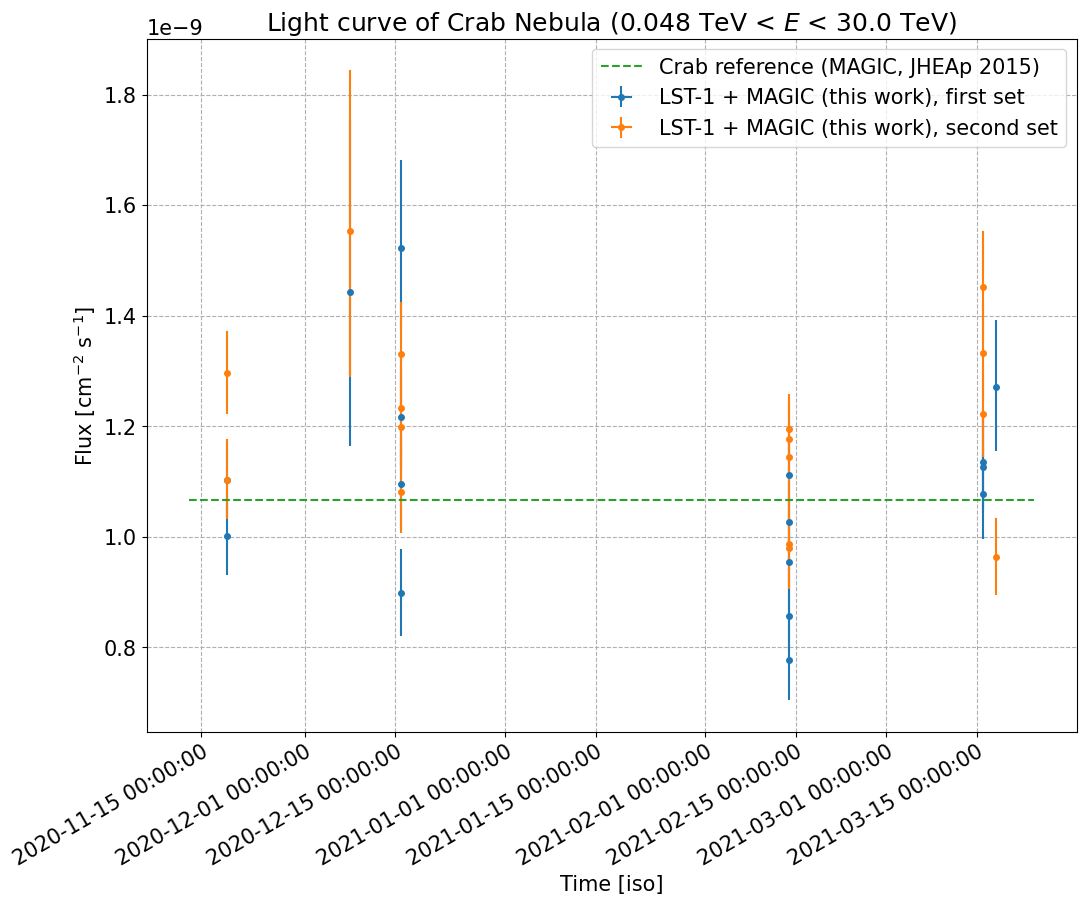

In [68]:
plt.figure()

lines = itertools.cycle(["--", "-.", ":"])

# Plot the light curve
ax = light_curve.plot(sed_type="flux", label="LST-1 + MAGIC (this work), first set")
if double:
    ax = light_curve_1.plot(sed_type="flux", label="LST-1 + MAGIC (this work), second set")


xlim = plt.xlim()

# Plot the reference flux
for label, model in reference_models.items():
    
    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.plot(xlim, np.repeat(integ_flux, 2), label=label, linestyle=next(lines))

energy_range = f"{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}"

ax.set_title(f"Light curve of {source_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_yscale("linear")
ax.legend()
ax.grid()
